In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from toolz import reduce, merge

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])
# use the same number of mice per age - only age 80

/tmp/ipykernel_9818/1105121986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_9818/1105121986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [8]:
sort_syllables = m_data.groupby('age', observed=True).mean().quantile(0.95).sort_values(ascending=False).index

In [9]:
df = m_data
# Initialize an empty list to store the bootstrapped data
bootstrapped_data = []

# Number of bootstraps
n_bootstraps = 1000

# Perform the bootstrapping
for i in tqdm(range(n_bootstraps)):
    # Set the random seed for reproducibility
    np.random.seed(i)
    
    # Sample 10 mice for each age
    sampled_df = df.groupby('age').apply(lambda x: x.sample(n=10, replace=True, random_state=i))
    
    # Calculate the average syllable usage per age
    avg_syllable_usage = sampled_df.groupby('age').mean()
    
    # Add the bootstrap index
    avg_syllable_usage['mouse'] = i
    
    # Append the results to the bootstrapped data list
    bootstrapped_data.append(avg_syllable_usage)

# Combine all bootstrapped data into a single dataframe
bootstrapped_df = pd.concat(bootstrapped_data)

# Reset index to have a proper structure
bootstrapped_df.set_index(['mouse'], inplace=True, append=True)

bootstrapped_df

  0%|          | 0/1000 [00:00<?, ?it/s]

,syllables,0,2,4,5,6,7,9,10,11,12,...,77,79,83,84,85,90,93,95,97,98
age,mouse,,,,,,,,,,,,,,,,,,,,,
4,0,0.003865,0.016639,0.003317,0.032554,0.002745,0.022267,0.034206,0.005760,0.039081,0.007952,...,0.001083,0.002881,0.005692,0.004070,0.007964,0.009319,0.004759,0.012866,0.001052,0.005102
8,0,0.006521,0.042242,0.008774,0.029731,0.003965,0.033681,0.036296,0.007005,0.041711,0.009610,...,0.002235,0.003631,0.004087,0.004413,0.006349,0.014863,0.003463,0.018407,0.001259,0.007275
12,0,0.004425,0.023509,0.018259,0.039414,0.008662,0.039509,0.034625,0.003194,0.033765,0.005869,...,0.004771,0.005108,0.005571,0.006958,0.002838,0.013321,0.006319,0.013882,0.002491,0.003771
20,0,0.005850,0.032767,0.023047,0.057017,0.006089,0.032948,0.030903,0.003461,0.016400,0.004409,...,0.003450,0.017123,0.010711,0.008901,0.001796,0.029782,0.005799,0.012289,0.009495,0.008587
24,0,0.003542,0.035998,0.029346,0.068043,0.002116,0.037959,0.029198,0.004480,0.016031,0.004614,...,0.001818,0.011085,0.011918,0.004844,0.003281,0.033022,0.004311,0.013352,0.004212,0.006287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,999,0.007284,0.017450,0.015023,0.090810,0.001263,0.055081,0.014614,0.002712,0.008572,0.001625,...,0.004742,0.015005,0.014524,0.006346,0.002561,0.023593,0.007921,0.011665,0.002122,0.007929
78,999,0.007999,0.026463,0.022323,0.088003,0.002628,0.053385,0.018326,0.000904,0.011169,0.001707,...,0.004695,0.013052,0.010460,0.007961,0.001592,0.034428,0.008946,0.021182,0.002439,0.010258
80,999,0.009191,0.018014,0.019473,0.091791,0.001747,0.047529,0.011471,0.002815,0.009743,0.003955,...,0.005143,0.010133,0.010965,0.004148,0.004509,0.021788,0.006248,0.013283,0.001250,0.007746


In [10]:
df = bootstrapped_df.copy()
n_sylls = 25
roll_size = 6
minp = 3

norms = {}
for mouse, _df in df.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    smooth_samples = _df[sort_syllables[:n_sylls]].rolling(roll_size, center=True, min_periods=minp).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    norms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
norms = pd.DataFrame(norms)

mask = norms.isna().sum(1) < 10
norms = norms[mask]
mnorms_melt = norms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')


In [11]:
df = f_data
# Initialize an empty list to store the bootstrapped data
bootstrapped_data = []

# Number of bootstraps
n_bootstraps = 1000

# Perform the bootstrapping
for i in tqdm(range(n_bootstraps)):
    # Set the random seed for reproducibility
    np.random.seed(i)
    
    # Sample 10 mice for each age
    sampled_df = df.groupby('age').apply(lambda x: x.sample(n=10, replace=True, random_state=i))
    
    # Calculate the average syllable usage per age
    avg_syllable_usage = sampled_df.groupby('age').mean()
    
    # Add the bootstrap index
    avg_syllable_usage['mouse'] = i
    
    # Append the results to the bootstrapped data list
    bootstrapped_data.append(avg_syllable_usage)

# Combine all bootstrapped data into a single dataframe
bootstrapped_df = pd.concat(bootstrapped_data)

# Reset index to have a proper structure
bootstrapped_df.set_index(['mouse'], inplace=True, append=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
df = bootstrapped_df.copy()
n_sylls = 25
roll_size = 6
minp = 3
norms = {}
for mouse, _df in df.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    smooth_samples = _df[sort_syllables[:n_sylls]].rolling(roll_size, center=True, min_periods=minp).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    norms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
norms = pd.DataFrame(norms)

mask = norms.isna().sum(1) < 10
norms = norms[mask]
fnorms_melt = norms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')

In [13]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

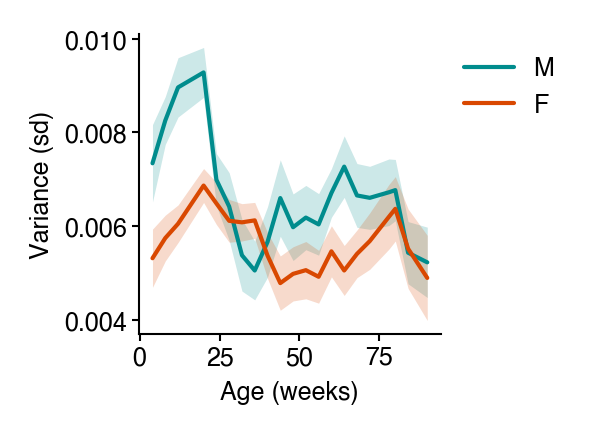

In [14]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=mnorms_melt, x='age', y='ar', errorbar='sd', err_kws=dict(lw=0), color=COLORMAPS.ont_male(255), label="M")
sns.lineplot(data=fnorms_melt, x='age', y='ar', errorbar='sd', ax=ax, err_kws=dict(lw=0), color=COLORMAPS.ont_female(255), label="F")
ax.set(ylabel="Variance (sd)", xlabel="Age (weeks)")
legend(ax)
sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ '07_24_fvm_aging_rate.pdf')

In [16]:
## stats

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import pinv_extended  
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate

In [18]:
import statsmodels.formula.api as smf

def ow_anova(data, dependent_var, factor1):
    """
    Perform two-way ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    # Fit an OLS model on the ranked data
    model = ols(f'ranked_response ~ {factor1}', data=align_data).fit()
    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=3)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df



def fit_1mixed_linear_models(data, dependent_var, factor1, group):
    
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]

    #formula = f'ranked_response ~ {factor1}*{group}'
    formula = f'ranked_response ~ {factor1}'
        
    # Fit the mixed linear model
    model = smf.mixedlm(formula, align_data, groups=f'{group}')
    result = model.fit()
    return result


def fit_2mixed_linear_models(data, dependent_var, factor1,factor2, group):
    
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    formula = f'ranked_response ~ {factor1}*C({factor2})'
        
    # Fit the mixed linear model
    model = smf.mixedlm(formula, align_data, groups=f'{group}')
    result = model.fit()
    return result


def extract_summary_to_dataframe(results, num_tests):
    summary_data = []

    for var, result in results.items():
        summary = result.summary()
        coefs = result.params
        pvalues = result.pvalues
        conf_int = result.conf_int()
        
        for param in coefs.index:
            pvalue_corrected = min(pvalues[param] * num_tests, 1.0)  # Apply Bonferroni correction
            
            summary_data.append({
                'Dependent Variable': var,
                'Parameter': param,
                'Coefficient': coefs[param],
                'P-value': pvalues[param],
                'Corrected P-value': pvalue_corrected,
                'CI Lower': conf_int[0][param],
                'CI Upper': conf_int[1][param]
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [20]:
mdf = mnorms_melt.copy()
fdf = fnorms_melt.copy()

fdf['sex']=str('f')
mdf['sex']=str('m')

data = pd.concat([mdf, fdf], ignore_index=True)

In [21]:
data

,age,mouse,ar,sex
0,4,0,0.006824,m
1,8,0,0.008214,m
2,12,0,0.008730,m
3,20,0,0.009209,m
4,24,0,0.007160,m
...,...,...,...,...
41995,72,999,0.006096,f
41996,78,999,0.006616,f
41997,80,999,0.006718,f
41998,84,999,0.005466,f


In [22]:
results={}

syll = ['ar']
temp = data.dropna().copy()
temp.reset_index(inplace=True)

for i in syll:
    result=fit_2mixed_linear_models(temp, i, 'age','sex','mouse')
    results[i] = result
num_tests = len(data.columns)  # Number of tests is the number of dependent variables (excluding 'age' and 'mouse')
summary_df = extract_summary_to_dataframe(results, num_tests)

# Print the DataFrame nicely
print(summary_df)
summary_df.to_csv('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/stats/aging_rate_fvm_ontogeny.csv')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  Dependent Variable        Parameter  Coefficient        P-value  \
0                 ar        Intercept     0.005975   0.000000e+00   
1                 ar      C(sex)[T.m]     0.001732   0.000000e+00   
2                 ar              age    -0.000007  9.405309e-162   
3                 ar  age:C(sex)[T.m]    -0.000015   0.000000e+00   
4                 ar        mouse Var     0.097016   2.433205e-70   

   Corrected P-value  CI Lower  CI Upper  
0       0.000000e+00  0.005942  0.006008  
1       0.000000e+00  0.001694  0.001771  
2      3.762124e-161 -0.000008 -0.000007  
3       0.000000e+00 -0.000016 -0.000015  
4       9.732819e-70  0.086292  0.107740  
